In [1]:
import os
import time

import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from sklearn.model_selection import StratifiedKFold, train_test_split

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
    confusion_matrix
)
from classification.utils.utils import accuracy

import tensorflow as tf
from keras import layers, models
import pandas as pd
import seaborn as sns

dataset = Dataset()

fm_dir = "data/feature_matrices/"
model_dir = "data/models/"

nclass = dataset.nclass
naudio = dataset.naudio
classnames = dataset.list_classes()
num_classes = len(classnames)

Iteration:  0
seed =  1739199224
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 551ms/step - accuracy: 0.4875 - loss: 197672.5156 - val_accuracy: 0.2361 - val_loss: 416365.4688
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.2333 - loss: 389129.7188 - val_accuracy: 0.2000 - val_loss: 2496987.0000
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.1083 - loss: 2666765.5000 - val_accuracy: 0.2000 - val_loss: 421140.1250
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.2167 - loss: 421655.0625 - val_accuracy: 0.2000 - val_loss: 364800.8750
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.2229 - loss: 421903.4062 - val_accuracy: 0.2056 - val_loss: 599942.4375
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.2562 - loss: 673682.6875 - val_accuracy: 0.2000 - val_loss: 1461949.1250
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.1958 - loss: 1223820.3750 - val_accuracy: 0.1611 - val_loss: 465826.7188
Epoch 8/20


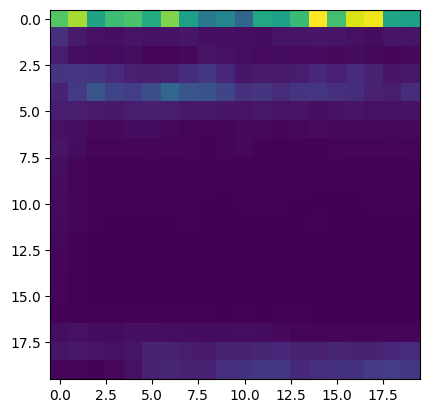

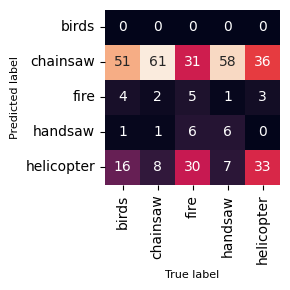

Test accuracy: 0.2916666567325592
birds: 0.00%
chainsaw: 65.83%
fire: 4.17%
handsaw: 3.89%
helicopter: 26.11%
Iteration:  1
seed =  1739199244
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 417ms/step - accuracy: 0.3583 - loss: 223571.2344 - val_accuracy: 0.3500 - val_loss: 126271.7656
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.2938 - loss: 191028.4062 - val_accuracy: 0.2806 - val_loss: 93619.2344
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.3042 - loss: 116270.9766 - val_accuracy: 0.2417 - val_loss: 56163.5352
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.2062 - loss: 89680.0234 - val_accuracy: 0.3194 - val_loss: 52406.6406
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.2333 - loss: 69442.0234 - val_accuracy: 0.3139 - val_loss: 112030.9688
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.3312 - loss: 83041.6953 - val_accuracy: 0.3333 - val_loss: 68292.8516
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/ste

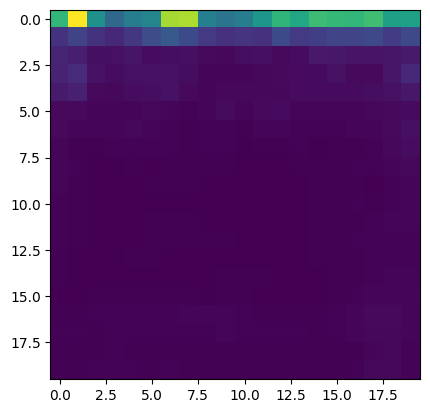

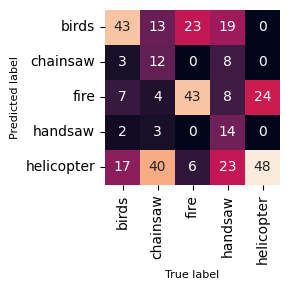

Test accuracy: 0.4444444477558136
birds: 27.22%
chainsaw: 6.39%
fire: 23.89%
handsaw: 5.28%
helicopter: 37.22%
Iteration:  2
seed =  1739199258
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step - accuracy: 0.3542 - loss: 15732.7920 - val_accuracy: 0.2833 - val_loss: 22045.3418
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.3917 - loss: 18364.2520 - val_accuracy: 0.4139 - val_loss: 19570.1309
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.3979 - loss: 15661.8584 - val_accuracy: 0.4000 - val_loss: 20030.7344
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.4292 - loss: 20927.0645 - val_accuracy: 0.3972 - val_loss: 17245.5547
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.4562 - loss: 17441.2949 - val_accuracy: 0.4750 - val_loss: 9669.9160
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.4500 - loss: 11616.5547 - val_accuracy: 0.5139 - val_loss: 8797.4150
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - ac

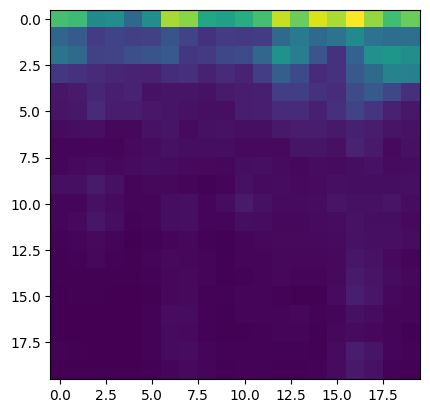

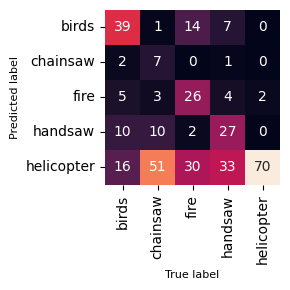

Test accuracy: 0.4694444537162781
birds: 16.94%
chainsaw: 2.78%
fire: 11.07%
handsaw: 13.61%
helicopter: 55.60%
Iteration:  3
seed =  1739199273
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.4021 - loss: 10231.3086 - val_accuracy: 0.4972 - val_loss: 6832.1543
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.3375 - loss: 9357.5273 - val_accuracy: 0.4361 - val_loss: 14862.6279
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5104 - loss: 12792.2666 - val_accuracy: 0.4556 - val_loss: 5461.1797
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.5979 - loss: 4863.9492 - val_accuracy: 0.4667 - val_loss: 5474.3320
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.3750 - loss: 7136.5249 - val_accuracy: 0.5000 - val_loss: 5381.8066
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.4562 - loss: 7898.8428 - val_accuracy: 0.4583 - val_loss: 5969.3037
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy

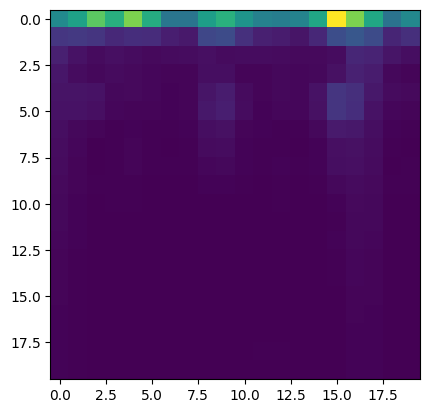

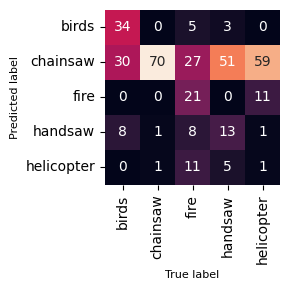

Test accuracy: 0.3861111104488373
birds: 11.67%
chainsaw: 65.85%
fire: 8.89%
handsaw: 8.61%
helicopter: 4.98%
Iteration:  4
seed =  1739199286
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 460ms/step - accuracy: 0.4562 - loss: 7642.6777 - val_accuracy: 0.4611 - val_loss: 4553.6021
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.5542 - loss: 4383.6221 - val_accuracy: 0.4361 - val_loss: 5501.1978
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.4083 - loss: 7688.4858 - val_accuracy: 0.4222 - val_loss: 6196.2769
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.5437 - loss: 5106.3062 - val_accuracy: 0.4583 - val_loss: 5539.8618
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.4729 - loss: 5945.9106 - val_accuracy: 0.4278 - val_loss: 5802.0205
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.6521 - loss: 2418.4998 - val_accuracy: 0.4278 - val_loss: 6461.9756
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.5

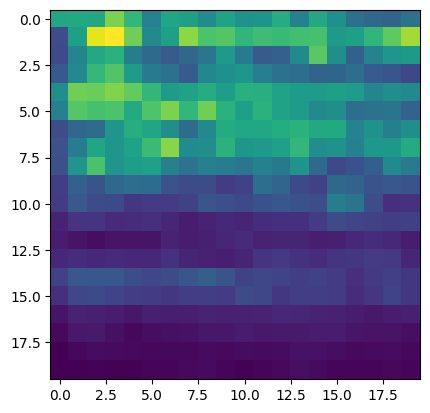

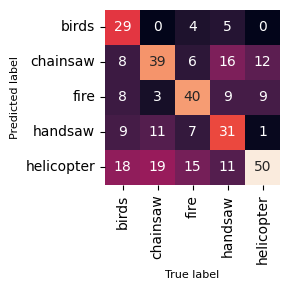

Test accuracy: 0.5249999761581421
birds: 10.56%
chainsaw: 22.50%
fire: 19.17%
handsaw: 16.39%
helicopter: 31.39%
Iteration:  5
seed =  1739199303
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 377ms/step - accuracy: 0.5271 - loss: 7549.1191 - val_accuracy: 0.6000 - val_loss: 3832.3625
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.4354 - loss: 10625.5127 - val_accuracy: 0.6000 - val_loss: 3650.7744
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.6042 - loss: 5139.3496 - val_accuracy: 0.5694 - val_loss: 3667.2104
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.3750 - loss: 8075.8438 - val_accuracy: 0.5500 - val_loss: 3778.6389
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.5750 - loss: 4234.3462 - val_accuracy: 0.5361 - val_loss: 3455.3965
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.5875 - loss: 3820.6780 - val_accuracy: 0.5667 - val_loss: 3326.0598
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy:

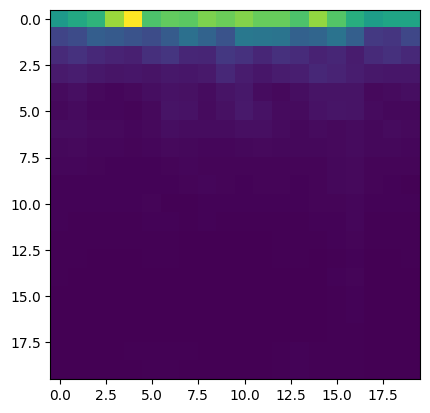

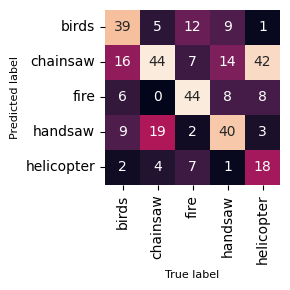

Test accuracy: 0.5138888955116272
birds: 18.33%
chainsaw: 34.17%
fire: 18.33%
handsaw: 20.28%
helicopter: 8.89%
Iteration:  6
seed =  1739199316
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.4667 - loss: 5417.7285 - val_accuracy: 0.6028 - val_loss: 2984.2827
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.2500 - loss: 6563.5605 - val_accuracy: 0.5694 - val_loss: 2990.7205
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.5479 - loss: 2591.5574 - val_accuracy: 0.5500 - val_loss: 3088.3718
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.4021 - loss: 4614.4668 - val_accuracy: 0.5278 - val_loss: 3273.7473
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.4229 - loss: 4168.9248 - val_accuracy: 0.5333 - val_loss: 3701.4277
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.3417 - loss: 5720.2480 - val_accuracy: 0.5389 - val_loss: 3772.3799
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0

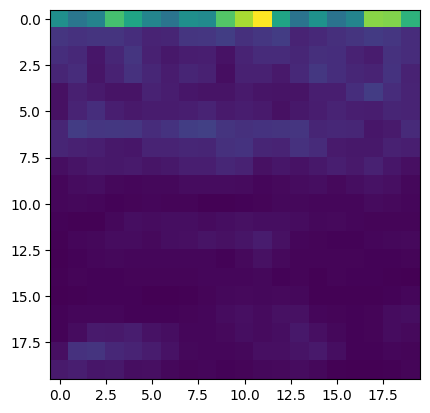

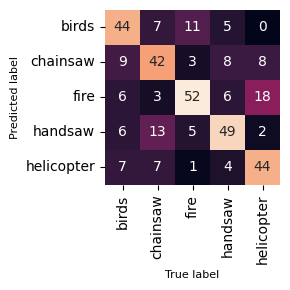

Test accuracy: 0.6416666507720947
birds: 18.61%
chainsaw: 19.44%
fire: 23.61%
handsaw: 20.83%
helicopter: 17.50%
Iteration:  7
seed =  1739199332
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 0.4229 - loss: 4799.5684 - val_accuracy: 0.5667 - val_loss: 2684.4412
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.5917 - loss: 1870.8127 - val_accuracy: 0.5611 - val_loss: 2948.3989
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.5708 - loss: 3565.5620 - val_accuracy: 0.5389 - val_loss: 3051.0007
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.6521 - loss: 1293.4363 - val_accuracy: 0.5000 - val_loss: 3208.5166
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7125 - loss: 1502.2965 - val_accuracy: 0.5139 - val_loss: 3260.5732
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.6146 - loss: 1579.2650 - val_accuracy: 0.5278 - val_loss: 3183.2822
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 

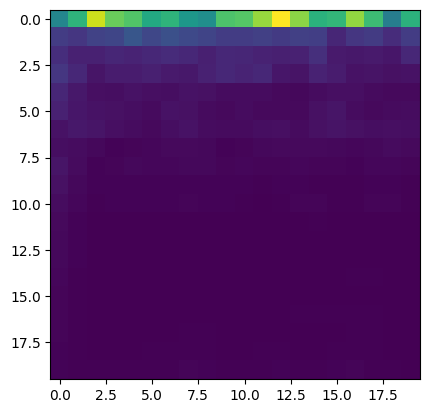

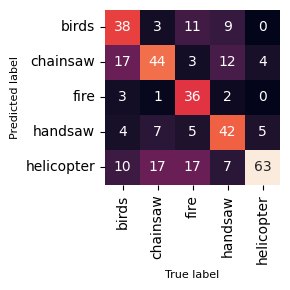

Test accuracy: 0.6194444298744202
birds: 17.04%
chainsaw: 22.22%
fire: 11.58%
handsaw: 17.50%
helicopter: 31.67%
Iteration:  8
seed =  1739199348
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step - accuracy: 0.4833 - loss: 5779.5283 - val_accuracy: 0.6750 - val_loss: 1766.0099
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5542 - loss: 2230.6052 - val_accuracy: 0.6694 - val_loss: 1735.3734
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6583 - loss: 3238.2771 - val_accuracy: 0.6444 - val_loss: 1815.5630
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 432ms/step - accuracy: 0.5000 - loss: 3124.5217 - val_accuracy: 0.6417 - val_loss: 1923.3080
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.5542 - loss: 2711.0005 - val_accuracy: 0.6417 - val_loss: 1943.6456
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.5000 - loss: 3314.8696 - val_accuracy: 0.6250 - val_loss: 1941.5182
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 

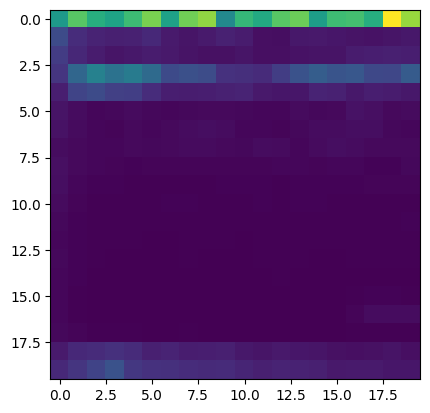

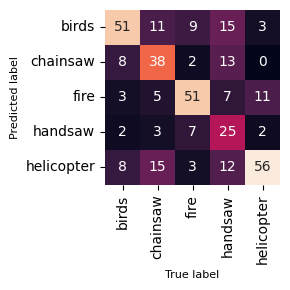

Test accuracy: 0.6138888597488403
birds: 24.72%
chainsaw: 16.94%
fire: 21.39%
handsaw: 10.83%
helicopter: 26.11%
Iteration:  9
seed =  1739199362
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - accuracy: 0.5104 - loss: 3948.7898 - val_accuracy: 0.6167 - val_loss: 1583.8541
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.5375 - loss: 4015.6060 - val_accuracy: 0.6389 - val_loss: 1495.4208
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.5604 - loss: 3747.7207 - val_accuracy: 0.6361 - val_loss: 1534.7865
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5604 - loss: 2726.9402 - val_accuracy: 0.6389 - val_loss: 1579.5118
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.5312 - loss: 2653.4839 - val_accuracy: 0.6472 - val_loss: 1650.4333
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.6625 - loss: 2828.0110 - val_accuracy: 0.6333 - val_loss: 1702.6216
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 

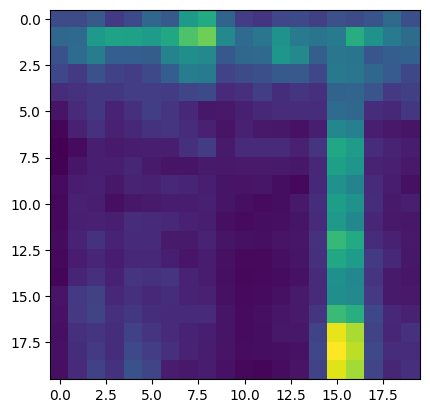

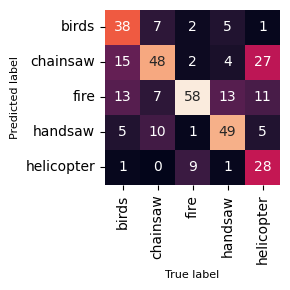

Test accuracy: 0.6138888597488403
birds: 14.72%
chainsaw: 26.67%
fire: 28.33%
handsaw: 19.44%
helicopter: 10.83%


In [2]:
for i in range(10):

    print("Iteration: ", i)

    np.random.seed(int(time.time()))

    print("seed = ", int(time.time()))
    
    # 'echo', 'time_shift', 'scaling', 'pitch_shift', 

    myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=1.5, data_aug=['time_shift'])

    feature_length = len(myds[classnames[0], 0])
    data_aug_factor = myds.data_aug_factor


    X_aug = np.zeros((data_aug_factor * nclass * naudio, 20, 20, 1))
    y_aug = np.zeros(data_aug_factor * nclass * naudio)

    for s in range(data_aug_factor):
        for idx in range(dataset.naudio):
            for class_idx, classname in enumerate(classnames):
                y_aug[s* nclass * naudio + class_idx * naudio + idx] = class_idx
                featvec = myds[classname, idx]
                X_aug[ s* nclass * naudio + class_idx * naudio + idx, :, :] = featvec.reshape(20, 20, 1)

    np.save(fm_dir + "feature_matrix_2D_aug.npy", X_aug)
    np.save(fm_dir + "labels_aug.npy", y_aug)

    X_aug = np.load(fm_dir + "feature_matrix_2D_aug.npy")
    y_aug = np.load(fm_dir + "labels_aug.npy")

    X_train, X_test, y_train, y_test = train_test_split(
        X_aug, y_aug, test_size=0.9, stratify=y_aug
    )
    """
    model = models.Sequential([
        layers.Input(shape=(20, 20, 1)),
        layers.Normalization(),
        layers.Conv2D(128, kernel_size=(4, 4), activation='leaky_relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(256, kernel_size=(4, 4), activation='leaky_relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(256, activation='leaky_relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adamw',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
    model.summary()
    """
    model = models.load_model(model_dir + "two.keras")
    
    ### change learining rate
    learning_rate = 0.1 * 10**(-np.log(i+1))
    
    optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), shuffle=True)

    # store the model

    model.save(model_dir + "two.keras", zipped=True)

    # evaluate the model

    plt.imshow(X_test[1, :, :, 0])

    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test loss: {test_loss}')

    # plot the confusion matrix
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    plt.figure(figsize=(3, 3))
    confmat = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(confmat.T, square=True, annot=True, fmt="d", cbar=False, xticklabels=classnames, yticklabels=classnames)
    plt.xlabel("True label", fontsize=8)
    plt.ylabel("Predicted label", fontsize=8)
    plt.tight_layout()
    plt.savefig(f"plots/confusion_matrix.pdf")
    plt.show()

    
    print(f'Test accuracy: {test_acc}')

     #calculate the f1 score
    from sklearn.metrics import f1_score
    f1 = f1_score(y_test, y_pred_classes, average='weighted')

    # calculate the percentage for each class
    class_percentages = np.mean(y_pred, axis=0) * 100
    for classname, percentage in zip(classnames, class_percentages):
        print(f'{classname}: {percentage:.2f}%')

In [3]:
### play all the sounds
audio_util = AudioUtil()

for classname in classnames:
    for idx in range(40):
        path = dataset.__getitem__((classname, idx))
        audio = audio_util.open(path)
        audio_util.play(audio)
        time.sleep(5)
        print(f'Playing {classname} {idx}')

TypeError: open() takes 1 positional argument but 2 were given

In [ ]:
# open the prediction file

data = pd.read_csv('C:\LELEC210X\LELEC210X\predictions.csv')

# plot the confusion matrix

y_pred = data['prediction']
for i in range(len(y_pred)):
    y_pred[i] = [float(x) for x in y_pred[i].replace('[', '').replace(']', '').split()]
    y_pred[i] = classnames[np.argmax(y_pred[i])]
y_test = np.repeat(classnames, 134)
y_pred_mean = data['mean_prediction']
for i in range(len(y_pred_mean)):
    y_pred_mean[i] = [float(x) for x in y_pred_mean[i].replace('[', '').replace(']', '').split()]
    y_pred_mean[i] = classnames[np.argmax(y_pred_mean[i])]
y_pred_weighted = data['weighted_prediction']
for i in range(len(y_pred_weighted)):
    y_pred_weighted[i] = [float(x) for x in y_pred_weighted[i].replace('[', '').replace(']', '').split()]
    y_pred_weighted[i] = classnames[np.argmax(y_pred_weighted[i])]
    
sns.set(font_scale=0.8)

plt.figure(figsize=(3, 3))
confmat = confusion_matrix(y_test, y_pred[:-1])
sns.heatmap(confmat.T, square=True, annot=True, fmt="d", cbar=False, xticklabels=classnames, yticklabels=classnames)
plt.xlabel("True label", fontsize=8)
plt.ylabel("Predicted label", fontsize=8)
plt.tight_layout()
plt.savefig(f"plots/confusion_matrix_direct_predictions.pdf")
plt.show()

plt.figure(figsize=(3, 3))
confmat = confusion_matrix(y_test, y_pred_mean[:-1])
sns.heatmap(confmat.T, square=True, annot=True, fmt="d", cbar=False, xticklabels=classnames, yticklabels=classnames)
plt.xlabel("True label", fontsize=8)
plt.ylabel("Predicted label", fontsize=8)
plt.tight_layout()
plt.savefig(f"plots/confusion_matrix_mean_predictions.pdf")
plt.show()

plt.figure(figsize=(3, 3))
confmat = confusion_matrix(y_test, y_pred_weighted[:-1])
sns.heatmap(confmat.T, square=True, annot=True, fmt="d", cbar=False, xticklabels=classnames, yticklabels=classnames)
plt.xlabel("True label", fontsize=8)
plt.ylabel("Predicted label", fontsize=8)
plt.tight_layout()
plt.savefig(f"plots/confusion_matrix_weighted_predictions.pdf")
plt.show()

# print the accuracy

print(f'Accuracy for the direct predictions: {accuracy(y_pred[:-1], y_test)}')
print(f'Accuracy for the mean predictions: {accuracy(y_pred_mean[:-1], y_test)}')
print(f'Accuracy for the weighted predictions: {accuracy(y_pred_weighted[:-1], y_test)}')

In [ ]:
# open the prediction file

data_new = pd.read_csv('C:\LELEC210X\LELEC210X\predictions_three_keras.csv')

# plot the confusion matrix

y_pred = data_new['prediction']
for i in range(len(y_pred)):
    y_pred[i] = [float(x) for x in y_pred[i].replace('[', '').replace(']', '').split()]
    y_pred[i] = classnames[np.argmax(y_pred[i])]
y_test = np.repeat(classnames, 658/5)
y_pred_mean = data_new['mean_prediction']
for i in range(len(y_pred_mean)):
    y_pred_mean[i] = [float(x) for x in y_pred_mean[i].replace('[', '').replace(']', '').split()]
    y_pred_mean[i] = classnames[np.argmax(y_pred_mean[i])]
y_pred_weighted = data_new['weighted_prediction']
for i in range(len(y_pred_weighted)):
    y_pred_weighted[i] = [float(x) for x in y_pred_weighted[i].replace('[', '').replace(']', '').split()]
    y_pred_weighted[i] = classnames[np.argmax(y_pred_weighted[i])]


plt.figure(figsize=(3, 3))
confmat = confusion_matrix(y_test, y_pred[:-4])
sns.heatmap(confmat.T, square=True, annot=True, fmt="d", cbar=False, xticklabels=classnames, yticklabels=classnames)
plt.xlabel("True label", fontsize=8)
plt.ylabel("Predicted label", fontsize=8)
plt.tight_layout()
plt.savefig(f"plots/confusion_matrix_prev_predictions.pdf")
plt.show()

# print the accuracy

print(f'Accuracy for the predictions: {accuracy(y_pred[:-4], y_test)}')
print(f'Accuracy for the mean predictions: {accuracy(y_pred_mean[:-4], y_test)}')
print(f'Accuracy for the weighted predictions: {accuracy(y_pred_weighted[:-4], y_test)}')